In [24]:
%reload_ext autoreload
%reload 2
%matplotlib inline

UsageError: Line magic function `%reload` not found.


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
# batch size
bs = 64

# getting the data

In [28]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [0]:
data_path = "/content/drive/My Drive/fast.ai v3/datasets/"

In [0]:
path = untar_data(url = URLs.PETS, dest = data_path)

In [31]:
path.ls()

[PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/"annotations"
path_img = path/"images"

In [33]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c:Union[pathlib.Path, str], check_ext:bool=True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [0]:
fnames = get_image_files(path_img)

In [35]:
fnames[:5]

[PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/keeshond_149.jpg'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/Bengal_146.jpg'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/Persian_83.jpg'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/japanese_chin_84.jpg'),
 PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/miniature_pinscher_5.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img,fnames,pat,
                                   ds_tfms = get_transforms(),
                                   size = 224,
                                   bs = bs
                                   ).normalize(imagenet_stats)

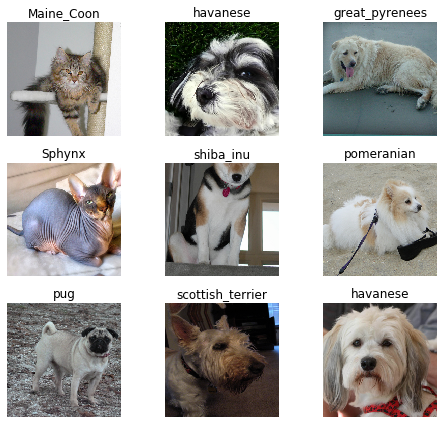

In [39]:
data.show_batch(rows = 3,figsize = (7,6))

In [40]:
len(data.classes)

37

# training: resnet34

In [0]:
learn = cnn_learner(data,models.resnet34,metrics = error_rate)

In [42]:
doc(cnn_learner)

In [43]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [44]:
doc(learn.fit_one_cycle)

lookup the one cycle policy here <br>
https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6

In [45]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.347821,0.340668,0.122463,25:27
1,0.614748,0.282895,0.090663,02:07
2,0.381777,0.243162,0.076455,02:04
3,0.271478,0.233300,0.073072,02:03


In [55]:
learn.save("stage-1",return_path=True)

PosixPath('/content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images/models/stage-1.pth')

# checking results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

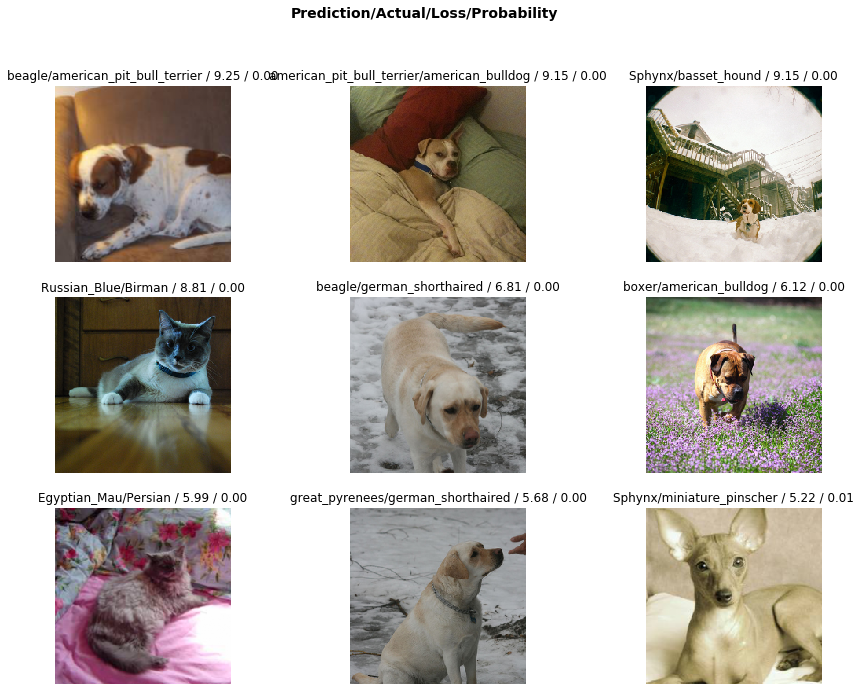

In [60]:
interp.plot_top_losses(9,figsize = (15,11))

In [61]:
doc(interp.plot_top_losses)

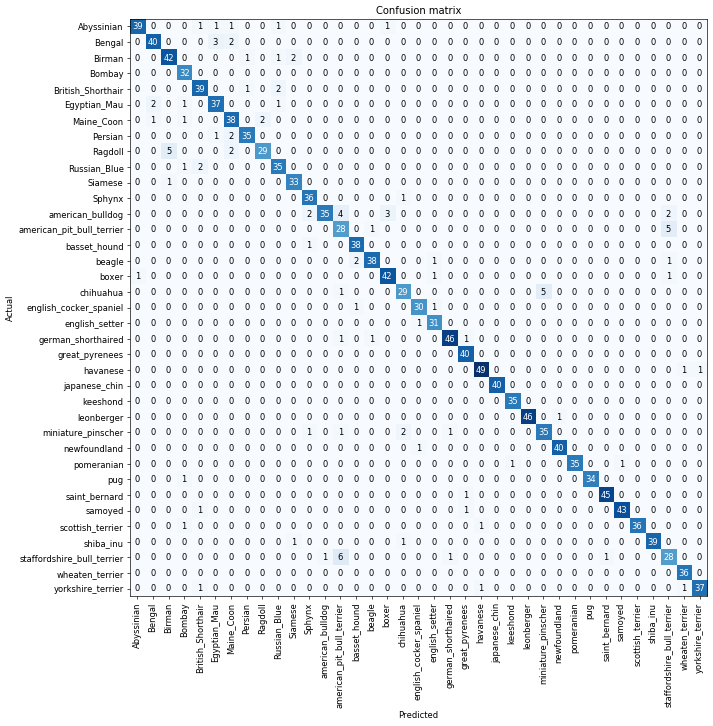

In [62]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [64]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('american_bulldog', 'boxer', 3),
 ('Bengal', 'Maine_Coon', 2),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Ragdoll', 'Maine_Coon', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'Sphynx', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('beagle', 'basset_hound', 2),
 ('miniature_pinscher', 'chihuahua', 2)]

the  model is showing normal behaviour, hence unfreezing and training some more

In [0]:
learn.unfreeze()

In [67]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.649132,0.392912,0.123139,02:12


In [69]:
doc(learn.load)

In [70]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
keeshond,Bengal,Persian,British_Shorthair,Bombay
Path: /content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
keeshond,japanese_chin,pomeranian,Russian_Blue,Russian_Blue
Path: /content/drive/My Drive/fast.ai v3/datasets/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv

In [71]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


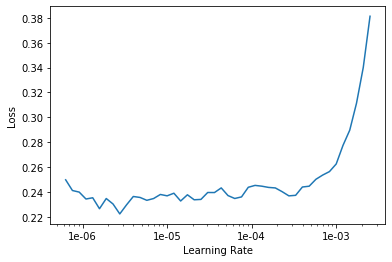

In [72]:
learn.recorder.plot()

In [75]:
help(slice)

Help on class slice in module builtins:

class slice(object)
 |  slice(stop)
 |  slice(start, stop[, step])
 |  
 |  Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  indices(...)
 |      S.indices(len) -> (start, stop, stride)
 |      
 | 

In [77]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.247335,0.217036,0.071042,02:12
1,0.210191,0.217497,0.073072,02:13


train_loss decreased but valid_loss increased a bit: looks like a minor case of overfitting